<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/BPR/BPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- GMF를 가지고 비교
- 메트릭은 NDCG, HIT 사용
- 동일한 Weigh, 배치마다 동일한 데이터셋으로 비교

In [1]:
# !pip install python-box

In [2]:
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
from tqdm import tqdm

from box import Box

warnings.filterwarnings(action='ignore')

data_dir = '/content/drive/MyDrive/RecsysTutorial/Data/MovieLens/'
model_dir = '/content/drive/MyDrive/RecsysTutorial/Model/'

In [3]:
seed = 22
random.seed(seed)
np.random.seed(seed)

# 학습 설정

In [4]:
config = {
    'top_k' : 10,
    'epochs' : 50,
    'lr' : 1e-03,
    'batch_size' : 256,

    'num_factor' :64,
    "reg" : 1e-5,
    'neg_samples' : 3,
}

config = Box(config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 데이터셋

In [5]:
class MakeDataset():
    def __init__(self, config, df : pd.DataFrame):
        self.config = config
        self.df = df
        self.user_encoder, self.user_decoder, self.item_encoder, self.item_decoder = self.get_encoder_decoder()
        self.num_users = len(self.user_encoder)
        self.num_items = len(self.item_encoder)
        self.all_items = [i for i in range(self.num_items)]

        self.df['userId'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df['movieId'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.user_neg_candidate = self.get_user_neg_candidate()

        self.train_set_user, self.train_set_item, self.train_set_target, self.test_set_user, self.test_set_item, self.test_set_target = self.train_test_data_split()

    def train_test_data_split(self):

        user_id_li = self.df['userId'].unique()

        train_set_item = []
        train_set_user = []
        train_set_target = []

        test_set_item = []
        test_set_user = []
        test_set_target = []

        for user_id in user_id_li:
            user_df = self.df[self.df['userId'] == user_id].sort_values('timestamp')
            movieId_li = user_df['movieId'].tolist()
            
            train_item = movieId_li[:-1]
            train_user = [user_id] * len(train_item)
            train_target = [1] * len(train_item)

            test_itme = [movieId_li[-1]] + np.random.choice(self.user_neg_candidate[user_id], 99, replace = False).tolist()
            test_user = [user_id] * len(test_itme)
            test_target = [1] + [0] * (len(test_itme) - 1)

            train_set_item += train_item
            train_set_user += train_user
            train_set_target += train_target

            test_set_item += test_itme
            test_set_user += test_user
            test_set_target += test_target

        return train_set_user, train_set_item, train_set_target, test_set_user, test_set_item, test_set_target

    def get_neg_samples(self, n : int, user_id_li):
        neg_samples_user = []
        neg_samples_item = []
        for u in user_id_li:
            u_neg_candidate = self.user_neg_candidate[u]
            for _ in range(n):
                neg_samples_item.append(u_neg_candidate[np.random.randint(len(u_neg_candidate))])
                neg_samples_user.append(u)

        return neg_samples_user, neg_samples_item

    def get_user_neg_candidate(self):
        user_candidate = {}
        for user_id in self.df['userId'].unique():
            movieId_li = self.df[self.df['userId'] == user_id]['movieId'].tolist()
            movieId_li = [movieId for movieId in movieId_li]
            user_candidate[user_id] = list(set(self.all_items) - set(movieId_li))
        
        return user_candidate

    def get_encoder_decoder(self):
        user_encoder, user_decoder = {}, {}
        for idx, user_id in enumerate(self.df['userId'].unique()):
            user_encoder[user_id] = idx
            user_decoder[idx] = user_id

        item_encoder, item_decoder = {}, {}
        for idx, item_id in enumerate(self.df['movieId'].unique()):
            item_encoder[item_id] = idx
            item_decoder[idx] = item_id
        
        return user_encoder, user_decoder, item_encoder, item_decoder
    
    def get_data(self, train : bool = True):
        if train: return self.train_set_user, self.train_set_item, self.train_set_target
        else: return self.test_set_user, self.test_set_item, self.test_set_target

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, set_user : list, set_item : list, set_target : list):
        self.set_user = set_user
        self.set_item = set_item
        self.set_target = set_target

    def __len__(self):
        return len(self.set_user)

    def __getitem__(self, idx):
        user = self.set_user[idx]
        item = self.set_item[idx]
        target = self.set_target[idx]

        return user, item, target

# 모델

In [7]:
class GMF(nn.Module):
    def __init__(self, num_user, num_item, num_factor):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_user, num_factor)
        self.item_emb = nn.Embedding(num_item, num_factor)
        
        self.predict_layer = nn.Sequential(
            nn.Linear(num_factor, 1, bias = False)
        )

        self._init_weight_()
    
    def _init_weight_(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)

        output = self.predict_layer(user_emb * item_emb)

        return output.view(-1)

# 학습 함수

In [8]:
def hit(target_item, pred_items):
    if target_item in pred_items:
        return 1
    return 0

def ndcg(target_item, pred_items):
    if target_item in pred_items:
        idx = pred_items.index(target_item)
        # 초기 인덱스가 0이기 때문에 +2 함
        return np.reciprocal(np.log2(idx + 2))
    return 0

def metrics(model, test_loader, top_k):
    model.eval()
    HR, NDCG = [], []
    with torch.no_grad():
        for user, item, _ in test_loader:
            user = user.to(device)
            item = item.to(device)

            predictions = model(user, item)
            # 가장 높은 top_k개 선택
            _, indices = torch.topk(predictions, top_k)
            # 해당 상품 index 선택
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            # 정답값 선택
            target_item = item[0].item()
            HR.append(hit(target_item, recommends))
            NDCG.append(ndcg(target_item, recommends))

    return np.mean(HR), np.mean(NDCG)

In [9]:
class BPR_Loss(nn.Module):
    def __init__(self):
        super(BPR_Loss, self).__init__()
    
    def forward(self, pos, neg):
        bpr_loss = -torch.mean(torch.log(torch.sigmoid(pos - neg)))
        return bpr_loss

# 학습

In [10]:
ratings_df = pd.read_csv(data_dir + 'ratings.csv')

dataset = MakeDataset(config = config, df = ratings_df)

train_set_user, train_set_item, train_set_target = dataset.get_data(train = True)
train_dataset = CustomDataset(set_user = train_set_user, set_item = train_set_item, set_target = train_set_target)
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

test_set_user, test_set_item, test_set_target = dataset.get_data(train = False)
test_dataset = CustomDataset(set_user = test_set_user, set_item = test_set_item, set_target = test_set_target)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = False, drop_last = False)

In [11]:
import copy
# 동일한 Weigh에서 초기화 시키기 위해서 copy 사용

gmf = GMF(num_user = dataset.num_users, num_item = dataset.num_items, num_factor = config.num_factor)
model = copy.deepcopy(gmf).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
loss_func = nn.BCELoss()

bpr_model = copy.deepcopy(gmf).to(device)
bpr_optimizer = torch.optim.Adam(bpr_model.parameters(), lr = config.lr)
bpr_loss_func = BPR_Loss()

In [12]:
non_bpr_model_loss_list = []
non_bpr_model_hr_list = []
non_bpr_model_ndcg_list = []

bpr_model_loss_list = []
bpr_model_hr_list = []
bpr_model_ndcg_list = []

best_metric = 0
bpr_best_metric = 0

for epoch in range(1, config.epochs + 1):
    # 학습
    model.train()
    bpr_model.train()

    train_loss = 0
    bpr_train_loss = 0

    for user, item, target in train_loader:
        # neg_sampling
        neg_user, neg_item = dataset.get_neg_samples(n = config.neg_samples, user_id_li = user.numpy().tolist())
        neg_target = [0] * len(neg_item)

        user, item, target = user.to(device), item.to(device), target.to(device).float()
        neg_user, neg_item, neg_target = torch.tensor(neg_user).to(device), torch.tensor(neg_item).to(device), torch.tensor(neg_target).to(device).float()

        all_user = torch.concat([user, torch.tensor(neg_user)])
        all_item = torch.concat([item, torch.tensor(neg_item)])
        all_target = torch.concat([target, torch.tensor(neg_target)])

        # BPR X 모델 학습
        optimizer.zero_grad()
        output = model(all_user, all_item)
        loss = loss_func(torch.sigmoid(output), all_target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # BPR O 모델 학습
        bpr_optimizer.zero_grad()
        output = bpr_model(all_user, all_item)
        pos_output, neg_output = torch.split(output, [len(user), len(neg_user)])
        pos_output = torch.concat([pos_output.view(-1, 1), pos_output.view(-1, 1), pos_output.view(-1, 1)], dim = 1).view(-1)

        loss = bpr_loss_func(pos_output, neg_output)

        loss.backward()
        bpr_optimizer.step()

        bpr_train_loss += loss.item()

    train_loss /= len(train_loader)
    bpr_train_loss /= len(train_loader)

    # 평가
    non_bpr_model_hr, non_bpr_model_ndcg = metrics(model = model, test_loader = test_loader, top_k = config.top_k)
    bpr_model_hr, bpr_model_ndcg = metrics(model = bpr_model, test_loader = test_loader, top_k = config.top_k)

    print(f"[EPOCH: {epoch}]")
    print(f"Non-BPR-GMF Train Loss: {train_loss:.4f}, HR: {non_bpr_model_hr:.4f}, NDCG: {non_bpr_model_ndcg:.4f}")
    print(f"BPR-GMF Train Loss: {bpr_train_loss:.4f}, HR: {bpr_model_hr:.4f}, NDCG: {bpr_model_ndcg:.4f}\n")

    non_bpr_model_loss_list.append(train_loss)
    non_bpr_model_hr_list.append(non_bpr_model_hr)
    non_bpr_model_ndcg_list.append(non_bpr_model_ndcg)

    bpr_model_loss_list.append(bpr_train_loss)
    bpr_model_hr_list.append(bpr_model_hr)
    bpr_model_ndcg_list.append(bpr_model_ndcg)

    if best_metric < non_bpr_model_hr:
        best_metric = non_bpr_model_hr
        torch.save(model.state_dict(), model_dir + f'Non-BPR-GMF.pt')

    if bpr_best_metric < bpr_model_ndcg:
        bpr_best_metric = bpr_model_ndcg
        torch.save(bpr_model.state_dict(), model_dir + f'BPR-GMF.pt')

[EPOCH: 1]
Non-BPR-GMF Train Loss: 0.6067, HR: 0.5142, NDCG: 0.3004
BPR-GMF Train Loss: 0.5743, HR: 0.5246, NDCG: 0.3059

[EPOCH: 2]
Non-BPR-GMF Train Loss: 0.3838, HR: 0.5306, NDCG: 0.3099
BPR-GMF Train Loss: 0.2970, HR: 0.5440, NDCG: 0.3184

[EPOCH: 3]
Non-BPR-GMF Train Loss: 0.3564, HR: 0.5395, NDCG: 0.3139
BPR-GMF Train Loss: 0.2492, HR: 0.5648, NDCG: 0.3349

[EPOCH: 4]
Non-BPR-GMF Train Loss: 0.3339, HR: 0.5663, NDCG: 0.3258
BPR-GMF Train Loss: 0.2138, HR: 0.5842, NDCG: 0.3511

[EPOCH: 5]
Non-BPR-GMF Train Loss: 0.3090, HR: 0.5872, NDCG: 0.3418
BPR-GMF Train Loss: 0.1903, HR: 0.6080, NDCG: 0.3641

[EPOCH: 6]
Non-BPR-GMF Train Loss: 0.2877, HR: 0.5961, NDCG: 0.3592
BPR-GMF Train Loss: 0.1670, HR: 0.6170, NDCG: 0.3806

[EPOCH: 7]
Non-BPR-GMF Train Loss: 0.2682, HR: 0.6304, NDCG: 0.3780
BPR-GMF Train Loss: 0.1483, HR: 0.6200, NDCG: 0.3849

[EPOCH: 8]
Non-BPR-GMF Train Loss: 0.2505, HR: 0.6259, NDCG: 0.3852
BPR-GMF Train Loss: 0.1312, HR: 0.6334, NDCG: 0.3968

[EPOCH: 9]
Non-BPR-GMF T

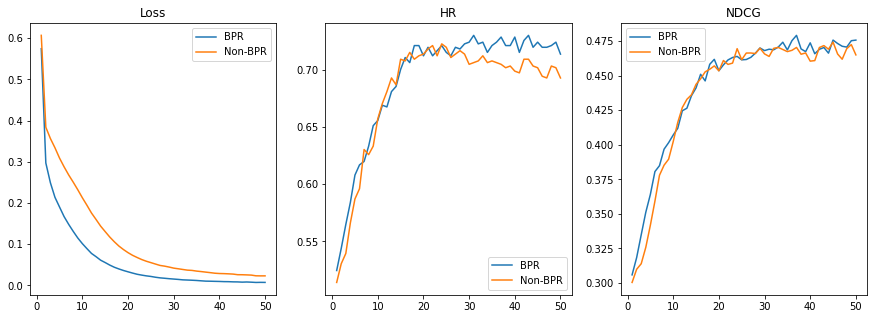

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.epochs + 1)]

ax[0].plot(epochs, bpr_model_loss_list, label = 'BPR')
ax[0].plot(epochs, non_bpr_model_loss_list, label = 'Non-BPR')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(epochs, bpr_model_hr_list, label = 'BPR')
ax[1].plot(epochs, non_bpr_model_hr_list, label = 'Non-BPR')
ax[1].set_title('HR')
ax[1].legend()

ax[2].plot(epochs, bpr_model_ndcg_list, label = 'BPR')
ax[2].plot(epochs, non_bpr_model_ndcg_list, label = 'Non-BPR')
ax[2].set_title('NDCG')
ax[2].legend()
plt.show()

BPR Loss를 사용하는 것이 성능, 수렴 측면에서 더 좋다는 것을 알 수 있음